# Rank based Methods 

**Author: Serge Rey <sjsrey@gmail.com>, Wei Kang <weikang9009@gmail.com>**

## Introduction

This notebook introduces two classic nonparametric statistics of exchange mobility and their spatial extensions. We will demonstrate the usage of these methods by an empirical study for understanding [regional exchange mobility pattern in Mexico](#Regional-exchange-mobility-pattern-in-Mexico). The dataset is the decennial per capita incomes observed from 1940 to 2000 for the 32 Mexican states and is used by Rey and Sastré-Gutiérrez (2010) and Rey (2016) for  investigating spatial income dynamics across the states of Mexico.

* [Kendall's $\tau$](#Kendall's-$\tau$)
    * [Classic Kendall's $\tau$](#Classic-Kendall's-$\tau$)
    * [Spatial Kendall's $\tau$](#Spatial-Kendall's-$\tau$)
    * [Inter- and Intra-regional decomposition of Kendall's $\tau$](#Inter--and-Intra-regional-decomposition-of-Kendall's-$\tau$)
    * [Local indicator of mobility association](#Local-indicator-of-mobility-association)
* [$\Theta$ statistic of exchange mobility](#$\Theta$-statistic-of-exchange-mobility)

## Regional exchange mobility pattern in Mexico 1940-2000

Firstly we load in the Mexico dataset:

In [1]:
from splot import mapping as maps
import pandas as pd
#import pysal
import libpysal
import libpysal.io.geotable as pdio
#shp_link = libpysal.examples.get_path('mexico.shp')
shp_link = libpysal.examples.get_path('mexicojoin.shp')
data_table = pdio.read_files(shp_link)
data_table.head()

,POLY_ID,AREA,CODE,NAME,PERIMETER,ACRES,HECTARES,PCGDP1940,PCGDP1950,PCGDP1960,...,GR9000,LPCGDP40,LPCGDP50,LPCGDP60,LPCGDP70,LPCGDP80,LPCGDP90,LPCGDP00,TEST,geometry
0,1,7.252751e+10,MX02,Baja California Norte,2040312.385,1.792187e+07,7252751.376,22361.0,20977.0,17865.0,...,0.05,4.35,4.32,4.25,4.40,4.47,4.43,4.48,1.0,<libpysal.cg.shapes.Polygon object at 0x1173e0...
1,2,7.225988e+10,MX03,Baja California Sur,2912880.772,1.785573e+07,7225987.769,9573.0,16013.0,16707.0,...,0.00,3.98,4.20,4.22,4.39,4.46,4.41,4.42,2.0,<libpysal.cg.shapes.Polygon object at 0x1173e0...
2,3,2.731957e+10,MX18,Nayarit,1034770.341,6.750785e+06,2731956.859,4836.0,7515.0,7621.0,...,-0.05,3.68,3.88,3.88,4.04,4.13,4.11,4.06,3.0,<libpysal.cg.shapes.Polygon object at 0x1173e0...
3,4,7.961008e+10,MX14,Jalisco,2324727.436,1.967200e+07,7961008.285,5309.0,8232.0,9953.0,...,0.03,3.73,3.92,4.00,4.21,4.32,4.30,4.33,4.0,<libpysal.cg.shapes.Polygon object at 0x1173e0...
4,5,5.467030e+09,MX01,Aguascalientes,313895.530,1.350927e+06,546702.985,10384.0,6234.0,8714.0,...,0.13,4.02,3.79,3.94,4.21,4.32,4.32,4.44,5.0,<libpysal.cg.shapes.Polygon object at 0x1173e0...


We will visualize the spatial distributions of per capita incomes in Mexican states across 1940 to 2000 to obtain a first impression of the dynamics. 

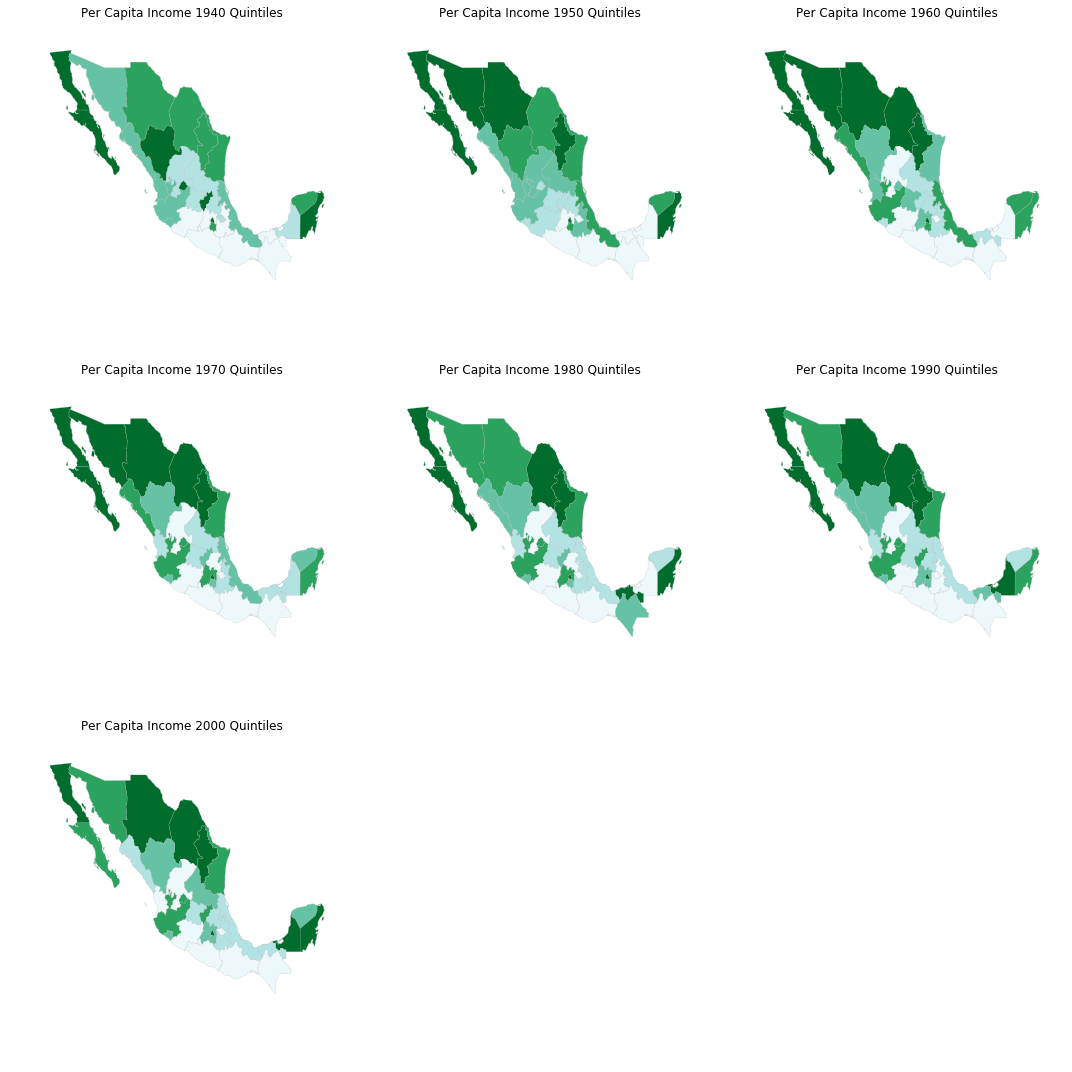

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
index_year = range(1940,2010,10)
fig, axes = plt.subplots(nrows=3, ncols=3,figsize = (15,15))
nn = 3
for i in range(3):
    if i==2:
        nn = 1
    for j in range(nn):
        ax = axes[i,j]
        maps.geoplot(data_table, col="PCGDP%d"%index_year[i*3+j],ax=ax,classi="Quantiles")
        ax.set_title('Per Capita Income %s Quintiles'%str(index_year[i*3+j]))
axes[-1, -2].axis('off')        
axes[-1, -1].axis('off')
plt.tight_layout()

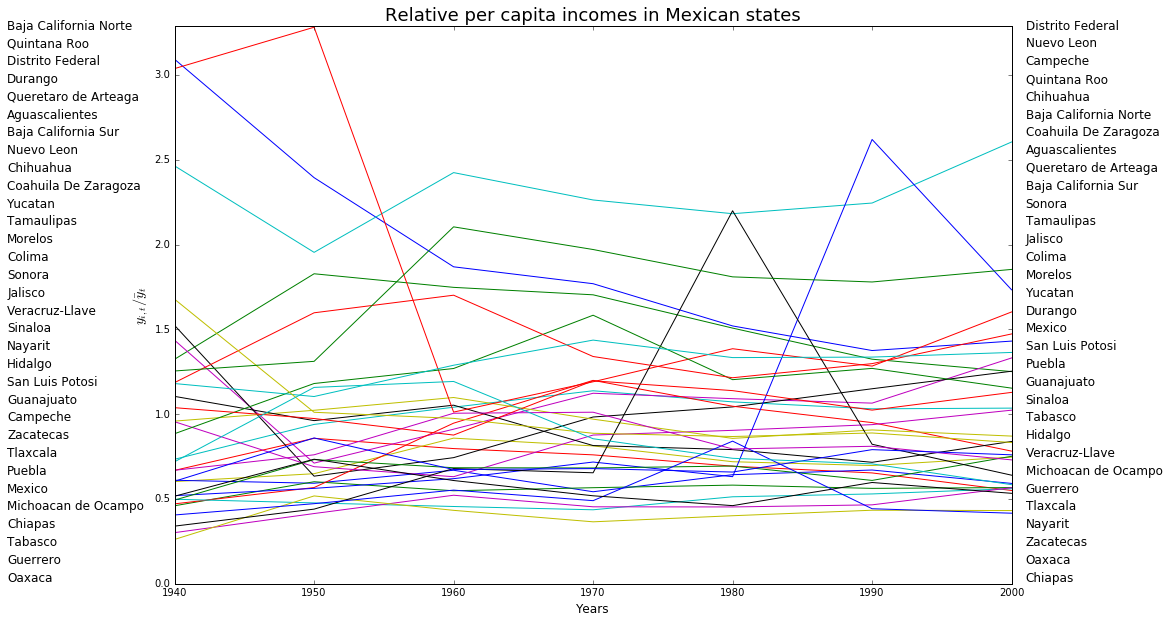

In [3]:
import numpy as np
rpci = np.zeros((32,7))
pci = np.zeros((32,7))
for i in range(len(index_year)):
    pci[:,i] = data_table["PCGDP%d"%index_year[i]]
    rpci[:,i] = pci[:,i] / pci[:,i].mean()
names = data_table["NAME"].as_matrix()
order1940 = np.argsort(rpci[:,0])
order2000 = np.argsort(rpci[:,-1])
names1940 = names[order1940[::-1]]
names2000 = names[order2000[::-1]]
first_last = np.vstack((names[order1940[::-1]],names[order2000[::-1]]))
from pylab import rcParams
rcParams['figure.figsize'] = 15,10
plt.plot(index_year,rpci.T)
for i in range(len(names)):
    plt.text(1928,3.27-(i*0.105), names1940[i],fontsize=12)
    plt.text(2001,3.27-(i*0.105), names2000[i],fontsize=12)
plt.xlim((index_year[0], index_year[-1]))
plt.ylim((0, 3.29))
plt.ylabel(r"$y_{i,t}/\bar{y}_t$",fontsize=14)
plt.xlabel('Years',fontsize=12)
plt.title('Relative per capita incomes in Mexican states',fontsize=18)

The above figure displays the trajectories of relative per capita incomes of 32 Mexican states. It is quite obvious that states were swapping positions across 1940-2000. We will demonstrate how to quantify the exchange mobility as well as how to assess the regional and local contribution to the overall exchange mobility. Similar to Rey (2016), the following “Esquivel99” regional scheme will be adopted for constructing the block weight matrix. 

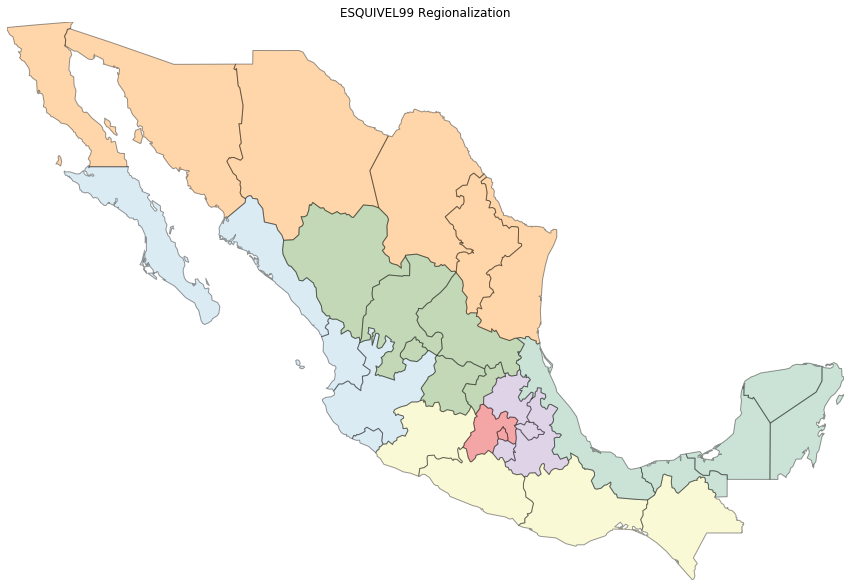

In [4]:
maps.plot_choropleth(shp_link, data_table["ESQUIVEL99"], "unique_values", title="ESQUIVEL99 Regionalization")

## Kendall's $\tau$

Kendall’s $\tau$ statistic is based on a comparison of the number of pairs of $n$ observations that have concordant ranks between two variables. For measuring exchange mobility in **giddy**, the two variables in question are the values of an attribute measured at two points in time over $n$ spatial units. This classic measure of rank correlation indicates how much relative stability there has been in the map pattern over the two periods. Spatial decomposition of Kendall’s $\tau$ could be classified into three spatial scales: global spatial decomposition , inter- and intra-regional decomposition and local spatial decomposition. More details will be given latter.

### Classic Kendall's $\tau$

Kendall's $\tau$ statistic is a global measure of exchange mobility. For $n$ spatial units over two periods, it is formally defined as follows:

$$\tau = \frac{c-d}{(n(n-1))/2}$$

where $c$ is the number of concordant pairs (two spatial units which do not exchange ranks over two periods), and $d$ is the number of discordant pairs (two spatial units which exchange ranks over two periods). $-1 \leq \tau \leq 1$. Smaller $\tau$ indicates higher exchange mobility.

We will construct a $Tau$ instance by specifying the incomes in two periods. Here, we look at the global exchange mobility between 1940 and 2000.

In [5]:
from giddy import rank
tau = rank.Tau(data_table["PCGDP1940"],data_table["PCGDP2000"])
tau

<giddy.rank.Tau instance at 0x105692c20>

In [6]:
tau.concordant

393.0

In [7]:
tau.discordant

103.0

There are 393 concordant pairs of Mexican states between 1940 and 2000, and 103 discordant pairs.

In [8]:
tau.tau

0.58467741935483875

In [9]:
tau.tau_p

2.566538721341827e-06

The observed Kendall's $\tau$ statistic is 0.585 and its p-value is 2.567e-06. Therefore, we will reject the null hypothesis of no assocation between 1940 and 2000.

### Spatial Kendall's $\tau$

The spatial Kendall's $\tau$ decomposes all pairs into those that are spatial neighbors and those that are not, and examines whether the rank correlation is different between the two sets (Rey, 2014). 

$$\tau_w = \frac{\iota'(W\circ S)\iota}{\iota'W \iota}$$

$W$ is the spatial weight matrix, $S$ is the concordance matrix and $\iota$ is the $(n,1)$ unity vector. The null hypothesis is the spatial randomness of rank exchanges. The inference of $\tau_w$ could be conducted based on random spatial permutation of incomes at two periods.  

To illustrate this we turn back to the case of regional incomes in Mexico over the 1940 to 2010 period:

In [10]:
import libpysal.api as ps
w = ps.block_weights(data_table["ESQUIVEL99"])
np.random.seed(12345)
tau_w = rank.SpatialTau(data_table["PCGDP1940"],data_table["PCGDP2000"],w,999) 

In [11]:
tau_w.concordant

393.0

In [12]:
tau_w.concordant_spatial

48

In [13]:
tau_w.discordant

103.0

In [14]:
tau_w.discordant_spatial

15

Out of 393 concordant pairs of spatial units, 48 belong to the same region (and are considered neighbors); out of 103 discordant pairs of spatial units, 15 belong to the same region.

In [15]:
tau_w.tau_spatial

0.52380952380952372

In [16]:
tau_w.tau_spatial_psim

0.001

The estimate of spatial Kendall's $\tau$ is 0.524 and its p-value is 0.001 which is much smaller than the significance level $0.05$. Therefore, we reject the null of spatial randomness of exchange mobility. The fact that $\tau_w=0.524$  is smaller than the global average $\tau=0.585$ implies that globally a significant number of rank exchanges happened between states within the same region though we do not know the specific region or regions hosting these rank exchanges.

### Inter- and Intra-regional decomposition of Kendall's $\tau$

### Local indicator of mobility association

## $\Theta$ statistic of exchange mobility

## Next steps

* Intra- and inter-decomposition of mobility association
* Local indicators of mobility association (LIMA)

## References
* Rey, Sergio J., and Myrna L. Sastré-Gutiérrez. 2010. “[Interregional Inequality Dynamics in Mexico](http://www.tandfonline.com/doi/abs/10.1080/17421772.2010.493955).” Spatial Economic Analysis 5 (3). Taylor & Francis: 277–98.
* Rey, Sergio J. 2014. “[Fast Algorithms for a Space-Time Concordance Measure](https://link.springer.com/article/10.1007/s00180-013-0461-2).” Computational Statistics 29 (3-4). Springer: 799–811.
* Rey, Sergio J. 2016. “[Space--Time Patterns of Rank Concordance: Local Indicators of Mobility Association with Application to Spatial Income Inequality Dynamics](http://www.tandfonline.com/doi/abs/10.1080/24694452.2016.1151336?journalCode=raag21).” Annals of the Association of American Geographers. Association of American Geographers 106 (4): 788–803.